# Preferential Bayesian Optimization: Multinomial Predictive Entropy Search
This notebook demonstrates the use of the Multinomial Predictive Entropy Search (MPES) acquisition function on ordinal (preference) data.

In [1]:
import numpy as np
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sys
import os
import pickle

from gpflow.utilities import set_trainable, print_summary
gpflow.config.set_default_summary_fmt("notebook")

sys.path.append(os.path.split(os.path.split(os.path.split(os.getcwd())[0])[0])[0]) # Move 3 levels up directory to import project files as module
import importlib
PBO = importlib.import_module("Top-k-Ranking-Bayesian-Optimization")


In [2]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "dejavuserif"

In [3]:
gpu_to_use = 0

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[gpu_to_use], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU


In [4]:
objective = PBO.objectives.forrester # The Forrester function is defined here 
objective_low = 0.
objective_high = 1.
objective_name = "Forrester"
acquisition_name = "MPES"
experiment_name = acquisition_name + "_" + objective_name

In [5]:
num_runs = 1 # number of experiments 
num_evals = 10 # number of queries
num_choices = 2 # 2 if pairwise 
input_dims = 1
num_maximizers = 20 # maximizer = x* that maximizes the objective function 
num_maximizers_init = 50
num_fourier_features = 1000
num_init_prefs = 5 # number of initial observations


In [6]:
### Unique to benchmark functions ###

num_samples = 100 
objective_dim = input_dims

# CHANGE 1: reduce the value of delta to avoid numerical error
# as k(x,x') = sigma^2 * exp( -[(x-x')/l]^2 )
# which could be very small if l is too small
# so we define l relatively by the range of input (objective_high - objective_low)
#   It is ok for the total number of observations > the total number of possible inputs
# because there is a noise in the observation, it might require repeated observations 
# at the same input pair to improve the confidence 
num_discrete_per_dim = 60
delta = (objective_high - objective_low) / num_discrete_per_dim

In [7]:
results_dir = os.getcwd() + '/results/' + experiment_name + '/'

try:
    # Create target Directory
    os.makedirs(results_dir)
    print("Directory " , results_dir ,  " created ") 
except FileExistsError:
    print("Directory " , results_dir ,  " already exists")

Directory  /home/johnson/Top-k-Ranking-Bayesian-Optimization/experiments/MPES/results/MPES_Forrester/  already exists


Plot of the Forrester function (global min at ~0.757):

(-0.0, 1.0)

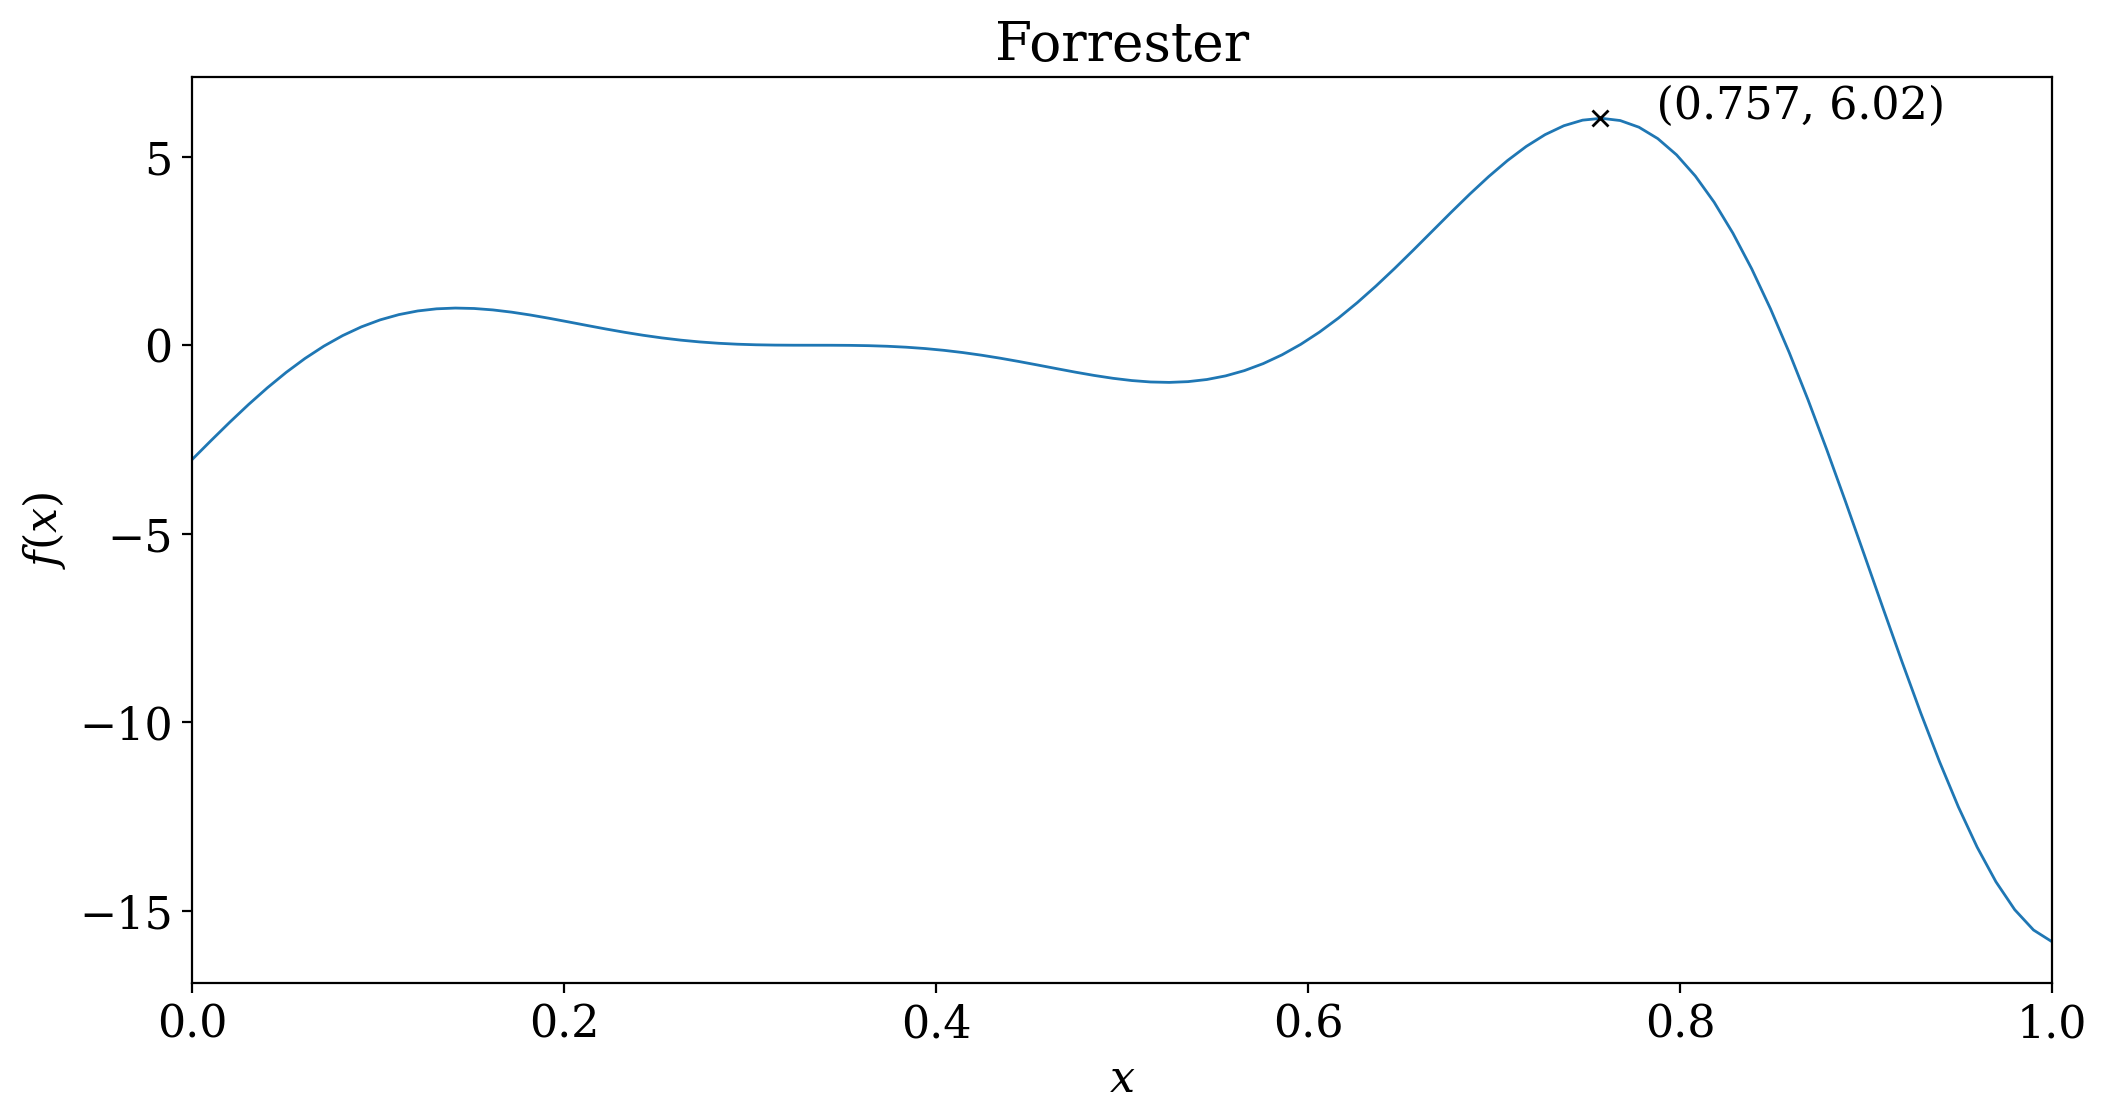

In [8]:
### Unique to benchmark functions ###

xx = np.linspace(0.0, 1.0, 100).reshape(100, 1)
plt.figure(figsize=(12, 6), dpi=200)
plt.plot(xx, -objective(xx), 'C0', linewidth=1)
plt.plot(0.757, 6.02074, 'kx')
plt.text(0.757, 6.02074, '    (0.757, 6.02)')
plt.title("Forrester")
plt.xlabel("$x$")
plt.ylabel('$f(x)$')
plt.xlim(-0.0, 1.0)

In [9]:
### Unique to benchmark functions ###

def plot_gp(model, X, y, title, cmap="Spectral"):
    #Plotting code from GPflow authors

    ## generate test points for prediction
    xx = np.linspace(-0.1, 1.1, 100).reshape(100, 1)  # test points must be of shape (N, D)

    ## predict mean and variance of latent GP at test points
    mean, var = model.predict_f(xx)

    ## generate 10 samples from posterior
    samples = model.predict_f_samples(xx, 10)  # shape (10, 100, 1)

    ## plot 
    plt.figure(figsize=(12, 6))
    plt.plot(X, y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 1.96 * np.sqrt(var[:,0]),
                     mean[:,0] + 1.96 * np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)

    plt.plot(xx, samples[:, :, 0].numpy().T, 'C0', linewidth=.5)
    plt.xlim(-0.1, 1.1)
    plt.title(title)

    plt.savefig(fname=results_dir + title + ".png")

In [10]:
def get_noisy_observation(X, objective): # noisy (human) observations
    f = PBO.objectives.objective_get_f_neg(X, objective)
    return PBO.observation_model.gen_observation_from_f(X, f, 1)

In [11]:
def train_and_visualize(X, y, title, lengthscale_init=None, signal_variance_init=None):

    # Train model with data 
    result = PBO.models.learning_fullgp.train_model_fullcov(
                        X, y, 
                        obj_low=objective_low,
                        obj_high=objective_high,
                        lengthscale_init=lengthscale_init,
                        signal_variance_init=signal_variance_init,
                        indifference_threshold=0.,
                        n_sample=1000, # number of samples to estimate the probabilities in Eq. 8
                        deterministic=True, # only sample f values once, not re-sampling
                        num_steps=500) # how many optimization steps to take when training model
    
    q_mu = result['q_mu']
    q_sqrt = result['q_sqrt']
    u = result['u']
    inputs = result['inputs']
    k = result['kernel']
        
    likelihood = gpflow.likelihoods.Gaussian()
    model = PBO.models.learning.init_SVGP_fullcov(q_mu, q_sqrt, u, k, likelihood)
    u_mean = q_mu.numpy()
    inducing_vars = u.numpy()
    
    # Visualize model ### Unique to benchmark functions ###
    plot_gp(model, inducing_vars, u_mean, title)
    
    return model, inputs, u_mean, inducing_vars

In [12]:
### Unique to benchmark functions ###

def uniform_grid(input_dims, num_discrete_per_dim, low=0., high=1.):
    """
    Returns an array with all possible permutations of discrete values in input_dims number of dimensions.
    :param input_dims: int
    :param num_discrete_per_dim: int
    :param low: int
    :param high: int
    :return: tensor of shape (num_discrete_per_dim ** input_dims, input_dims)
    """
    num_points = num_discrete_per_dim ** input_dims
    out = np.zeros([num_points, input_dims])
    discrete_points = np.linspace(low, high, num_discrete_per_dim)
    for i in range(num_points):
        for dim in range(input_dims):
            val = num_discrete_per_dim ** (dim)
            out[i, dim] = discrete_points[int((i // val) % num_discrete_per_dim)]
    return out

This function is our main metric for the performance of the acquisition function: The closer the model's best guess to the target (in this case, the global minimum of the Forrester function), the better.

In [13]:
def best_guess(model):
    """
    Returns a GP model's best guess of the global maximum of f.
    """
    xx = PBO.models.learning_fullgp.get_all_discrete_inputs(objective_low, objective_high, objective_dim, delta)
    res = model.predict_f(xx)[0].numpy()
    return xx[np.argmax(res)]

Store the results in these arrays:

In [14]:
num_data_at_end = int(num_init_prefs + num_evals)
X_results = np.zeros([num_runs, num_data_at_end, num_choices, input_dims])
y_results = np.zeros([num_runs, num_data_at_end, 1, input_dims])
best_guess_results = np.zeros([num_runs, num_evals, input_dims]) # immediate regret 

Create the initial values for each run:

In [15]:
np.random.seed(0)

### Unique for benchmark functions ### 
init_vals = np.zeros([num_runs, num_init_prefs, num_choices, input_dims])

for run in range(num_runs):
    for i in range(num_init_prefs):
        init_vals[run,i] = PBO.models.learning_fullgp.get_random_inputs(
                                objective_low, 
                                objective_high, 
                                objective_dim, 
                                delta,
                                size=num_choices,
                                with_replacement=False,
                                exclude_inputs=None)

The following loops carry out the Bayesian optimization algorithm over a number of runs, with a fixed number of evaluations per run.


Beginning run 0
Optimizer config:  {'name': 'RMSprop', 'learning_rate': 0.001, 'decay': 0.0, 'rho': 0.0, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
Indifference_threshold is fixed at 0.0
Initialize lengthscale at [0.256]
       signal variance at 1.0
   Initial negative ELBO: 1569762739.942786
Negative ELBO at step 0: 1538001559.615867 in 0.0483s
Beginning evaluation 0
Evaluation 0: Sampling maximizers
Loss at step 0: -26.055598793956584
Loss at step 500: -188.30590165720594
Loss at step 1000: -188.30591882913896
Loss at step 1500: -188.3059318969875
Loss at step 2000: -188.3059427729006
Loss at step 2500: -188.3059522224021
test.shape =  (20, 50, 1)
tf.Tensor(
[[0.93345797]
 [0.0277272 ]
 [0.04084206]
 [0.93241065]
 [0.03462343]
 [0.01965105]
 [0.18361672]
 [0.        ]
 [0.02608894]
 [0.07957537]
 [0.06211924]
 [0.94327808]
 [0.16923985]
 [0.9332566 ]
 [0.92984953]
 [0.93134354]
 [0.93310141]
 [0.        ]
 [0.93307821]
 [0.04831208]], shape=(20, 1), dtype=float64)
Evalua

KeyboardInterrupt: 

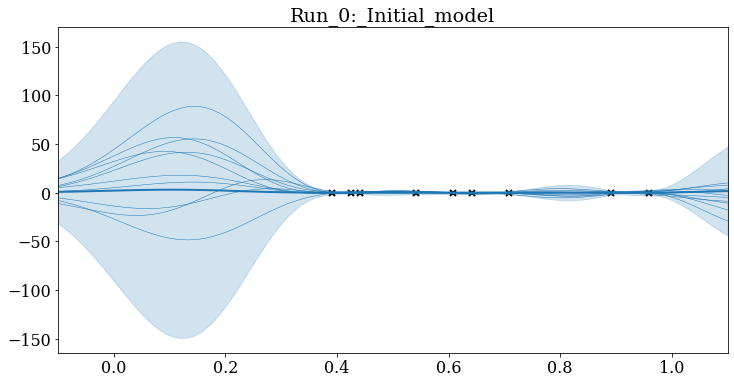

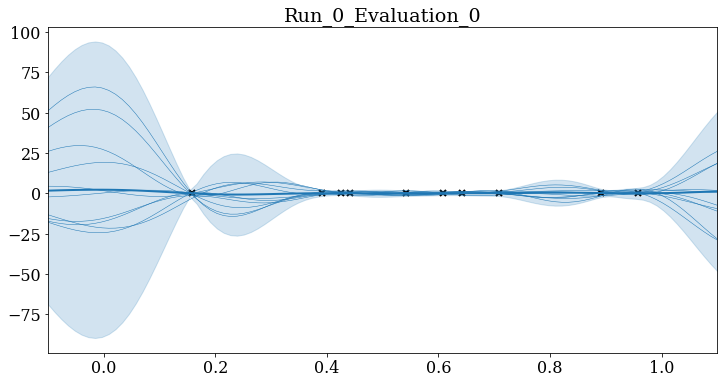

In [24]:
# CHANGE 2: remove the lengthscale_init and signal_variance_init
# as it makes the optimization stuck in local optima (a very small lengthscale)
# At each iteration, we optimize with the initial lengthscale = (objective_high - objective_low) / 2
# so that it can discover an optima with large lengthscale instead
for run in range(num_runs):
    print("")
    print("==================")
    print("Beginning run %s" % (run))
    
    X = init_vals[run]
    y = get_noisy_observation(X, objective)
    
    model, inputs, u_mean, inducing_vars = train_and_visualize(X, y, 
                                                        "Run_{}:_Initial_model".format(run))
    
    for evaluation in range(num_evals):
        print("Beginning evaluation %s" % (evaluation))

        # Sample possible next queries
        samples = PBO.models.learning_fullgp.sample_inputs(inputs.numpy(), 
                                                        num_samples, 
                                                        num_choices, 
                                                        min_val=objective_low, 
                                                        max_val=objective_high, 
                                                        delta=delta)
    
        # Sample maximizers
        print("Evaluation %s: Sampling maximizers" % (evaluation))
        maximizers = PBO.fourier_features.sample_maximizers(X=inducing_vars, 
                                                            count=num_maximizers,
                                                            n_init=num_maximizers_init,
                                                            D=num_fourier_features,
                                                            model=model,
                                                            min_val=objective_low,
                                                            max_val=objective_high) #,
                                                           # num_steps=500) # Added by Leah Chong
        print(maximizers)

        # Calculate PES value I for each possible next query
        print("Evaluation %s: Calculating I" % (evaluation))
        I_vals = PBO.acquisitions.pes.I_batch(samples, maximizers, model) # Takes time

        # Select query that maximizes I
        next_idx = np.argmax(I_vals)
        next_query = samples[next_idx]
        print("Evaluation %s: Next query is %s with I value of %s" % (evaluation, next_query, I_vals[next_idx]))

        X = np.concatenate([X, [next_query]])
        # Evaluate objective function
        y = np.concatenate([y, get_noisy_observation(np.expand_dims(next_query, axis=0), objective)], axis=0)
        
        print("Evaluation %s: Training model" % (evaluation))
        model, inputs, u_mean, inducing_vars = train_and_visualize(X, y,  
                                                                   "Run_{}_Evaluation_{}".format(run, evaluation)) 
                                                                                                # Takes time
        # print_summary(model)

        best_guess_results[run, evaluation, :] = best_guess(model)

        print("Best_guess f({}) = {}".format(
                best_guess_results[run, evaluation, :], 
                objective(best_guess_results[run, evaluation, :])))
        
                
        # Save model
        pickle.dump((X, y, inputs, 
                     model.kernel.variance, 
                     model.kernel.lengthscale, 
                     model.likelihood.variance, 
                     inducing_vars, 
                     model.q_mu, 
                     model.q_sqrt, 
                     maximizers), 
                    open(results_dir + "Model_Run_{}_Evaluation_{}.p".format(run, evaluation), "wb"))

    X_results[run] = X
    y_results[run] = y

In [17]:
pickle.dump((X_results, y_results, best_guess_results), 
            open(results_dir + acquisition_name + "_" + objective_name + "_" + "Xybestguess.p", "wb"))

In [18]:
### Unique to benchmark functions ###

global_min = np.min(objective(PBO.models.learning_fullgp.get_all_discrete_inputs(objective_low, objective_high, objective_dim, delta)))
metric = best_guess_results

In [19]:
ir = objective(metric) - global_min
mean = np.mean(ir, axis=0)
std_dev = np.std(ir, axis=0)
std_err = std_dev / np.sqrt(ir.shape[0])

In [20]:
print("Mean immediate regret at each evaluation averaged across all runs:")
print(mean)

Mean immediate regret at each evaluation averaged across all runs:
[6.01346077 5.99014588 8.63534079 5.08499725 6.01346077 5.24121014
 5.51708826 5.03391483 5.08499725 5.16607414]


In [21]:
print("Standard error of immediate regret at each evaluation averaged across all runs:")
print(std_err)

Standard error of immediate regret at each evaluation averaged across all runs:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [22]:
with open(results_dir + acquisition_name + "_" + objective_name + "_" + "mean_sem" + ".txt", "w") as text_file:
    print("Mean immediate regret at each evaluation averaged across all runs:", file=text_file)
    print(mean, file=text_file)
    print("Standard error of immediate regret at each evaluation averaged across all runs:", file=text_file)
    print(std_err, file=text_file)

In [23]:
pickle.dump((mean, std_err), open(results_dir + acquisition_name + "_" + objective_name + "_" + "mean_sem.p", "wb"))